# Autograd

1. Autograd是一个反向自动微分系统。从概念上看,在执行forward pass中的函数运算的同时，autograd会记录一个有向无环图(DAG),这个图上记录了所有执行过的operation。这个图上,leaf是input tensor,root是output tensor。在执行backward pass时，通过从root到leaf的方向tracing此图,就可以用链式法则自动计算梯度。 

2. **从具体的执行来看，autograd用Function objects graph来表达上述DAG。** \
(1) tensor使用的function是**torch.autograd.Function**的实例。这些function class中都定义了forward和backward函数。用他们对tensor做运算时，会自动创建计算图。\
(2) 可以apply()Function objects graph来计算评估图的结果。\
(3) 计算Forward pass时,autograd在执行对应的function的同时，还会构建一个graph来表示这些将要计算梯度的function.每个torch.Tensor的.grad_fn属性都是进入此图的入口。完成Forward pass后,就可以在反向传播中evaluate the graph以计算梯度。

3. **每个迭代都会从零开始重新创建图。** 这种设计是为了让forward pass中的运算过程可以使用任意Python control flow statements。因为一旦有了control flow statements，每次迭代中图的形状和大小就可能发生变化。每次迭代都重新创建图的好处是，在启动训练之前,不必编码所有可能的path。实际运行了哪些函数，最后就求哪些函数对应的梯度。

In [1]:
import torch

x = torch.ones(5)   # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)  # 要计算梯度
b = torch.randn(3, requires_grad=True)     # 要计算梯度
z = x @ w + b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

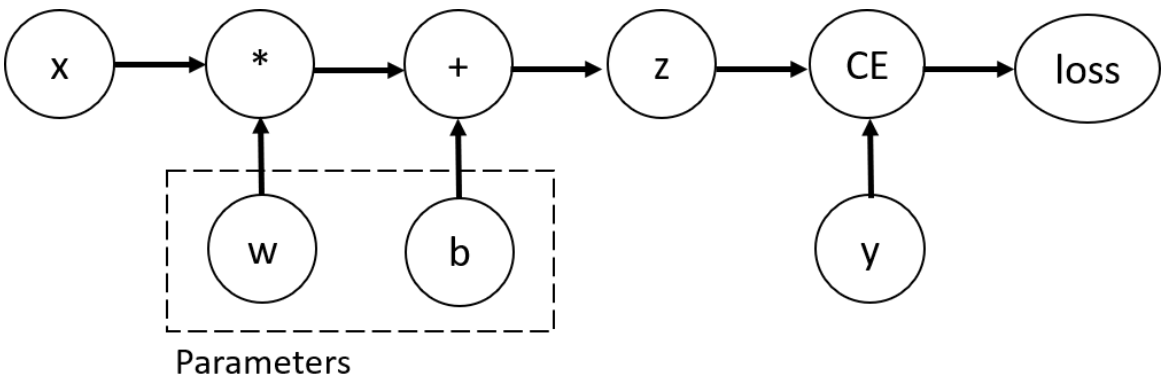

In [2]:
# tensor的grad_fn属性中存放了ref to the BP function
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7f597c1a00a0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f597c1a0c40>


### 计算梯度
1. 只有计算图中leaf nodes(requires_grad设为True时)才有grad properties，其他nodes都没有。
2. 一个计算图默认只能做一次BP。这是pytorch基于性能考虑设置的规则。如果要多次BP，要在backward call中设置参数retain_graph=True。

In [3]:
loss.backward()
print(w.grad)
print(b.grad)
print(x.grad)

tensor([[0.0012, 0.2839, 0.0744],
        [0.0012, 0.2839, 0.0744],
        [0.0012, 0.2839, 0.0744],
        [0.0012, 0.2839, 0.0744],
        [0.0012, 0.2839, 0.0744]])
tensor([0.0012, 0.2839, 0.0744])
None


### disable gradient tracking
默认所有requires_grad=True的tensor都会被track computational history。\
**不需要做gradient computation的典型场景：** \
(1)model已经train好了，只做inference，不需要好用资源track history\
(2)frozen参数来做finetune\
**两种方式disable gradient tracking：**\
(1)with torch.no_grad() block\
(2)tensor的detach method

In [4]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


In [5]:
z = torch.matmul(x, w)+b
print(z.requires_grad)
z_det = z.detach()
print(z_det.requires_grad)

True
False


## directed acyclic graph(DAG)
1. DAG由Function对象组成
2. 叶节点是input tensor，根节点是output tensor，通过从root到leaves遍历graph，可以用chainrule自动计算gradients
3. forward pass中，autograd会同时做两件事：\
(1)执行forward operation，计算tensor\
(2)将operation的gradient function存到DAG中
4. 当.backward()被调用的时候，就会做backward pass。此时autograd会做3件事：
(1)用每个.grad_fn计算梯度\
(2)将梯度累积到各自对应tensor的.grad属性中\
(3)使用chain rule，向leaf tensor传梯度